## ピークコール後のファイルを用いてボックスプロットを作成する

Rを使用してボックスプロットを作図する。  
ピークコールを行った後のファイルについて解析を行う。  
NOR,EOR,CORの定義、データの抽出は4_chipannoで行っている。

### Naive　VS　5h_activated　VS　Shared

最初に使用するlibraryの読み込みを行う。  
2回実行することで、正常に動作しているか確認することができる。  
実行1回目は読み込みが行われ、2回目を実行してログが何も出なければ正常に動作している。

In [93]:
# 使用するlibraryの読み込み
library(ggplot2)
library(readr)
library(dplyr)

In [ ]:
#　使用するlibraryが正常に動作するか確認する
library(ggplot2)
library(readr)
library(dplyr)

In [94]:
# インプットに使用するファイル名を定義する
sample1_file <- '/home/inou_doi/demo/6_overlap/bedtools_intersect2/NOR.narrowPeak'
sample2_file <- '/home/inou_doi/demo/6_overlap/bedtools_intersect2/EOR.narrowPeak'
sample3_file <- '/home/inou_doi/demo/6_overlap/bedtools_intersect2/COR.narrowPeak'

In [95]:
# ファイルをデータフレームとして読み込む
sample1_data <- read.table(sample1_file, header = FALSE)
sample2_data <- read.table(sample2_file, header = FALSE)
sample3_data <- read.table(sample3_file, header = FALSE)

In [96]:
# データフレーム内のカラムの名前を定義する。
colnames(sample1_data) <- c("chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak")
colnames(sample2_data) <- c("chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak")
colnames(sample3_data) <- c("chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak")

In [97]:
# 正しく定義されているか、確認を行う
print(head(sample1_data))

  chrom   start     end               name score strand signalValue   pValue
1  chr1  994744  995099  SRR7475870_peak_8    72      .     5.21978 10.16014
2  chr1 1071980 1073010 SRR7475870_peak_12    81      .     4.95690 11.01710
3  chr1 1079524 1079793 SRR7475870_peak_13    31      .     3.80117  5.77445
4  chr1 1092847 1093145 SRR7475870_peak_14    39      .     4.14201  6.62784
5  chr1 1284532 1285147 SRR7475870_peak_20    53      .     4.08163  8.17034
6  chr1 1711589 1712100 SRR7475870_peak_35    50      .     3.43407  7.85051
   qValue peak
1 7.28096  163
2 8.10184  618
3 3.12001   91
4 3.92032   49
5 5.38369  230
6 5.07881  323


In [98]:
# サンプルの表示名を定義する
sample1_data$Sample <- "Naive"
sample2_data$Sample <- "5h_activated"
sample3_data$Sample <- "Shared"

In [99]:
#リストを作成し、格納する
data_list <- list(Sample1 = sample1_data, Sample2 = sample2_data, Sample3 = sample3_data)

ggplot() プロット作成を行うコマンド。  
 geom_boxplot() データの分布をボックスプロットで可視化するためのジオメトリ。  
  data= 使用するデータセットを指定する。  
  aes= x軸とy軸を設定する。  
  fill= 色を指定する。  
  alfa= 塗りつぶしの透明度を指定する（0：完全透明、1：不透明）。  
 lab() グラフのラベルを設定する。グラフのタイトル、x軸のラベル、y軸のラベルを設定できる。  
 theme() グラフのテーマを調整できる。
 　axis.text.x= ｘ軸ラベルの設定を指定する。  
   element_text() テキストの要素を指定できる。フォントサイズ、フォントの種類、角度、色、配置などを設定できる。

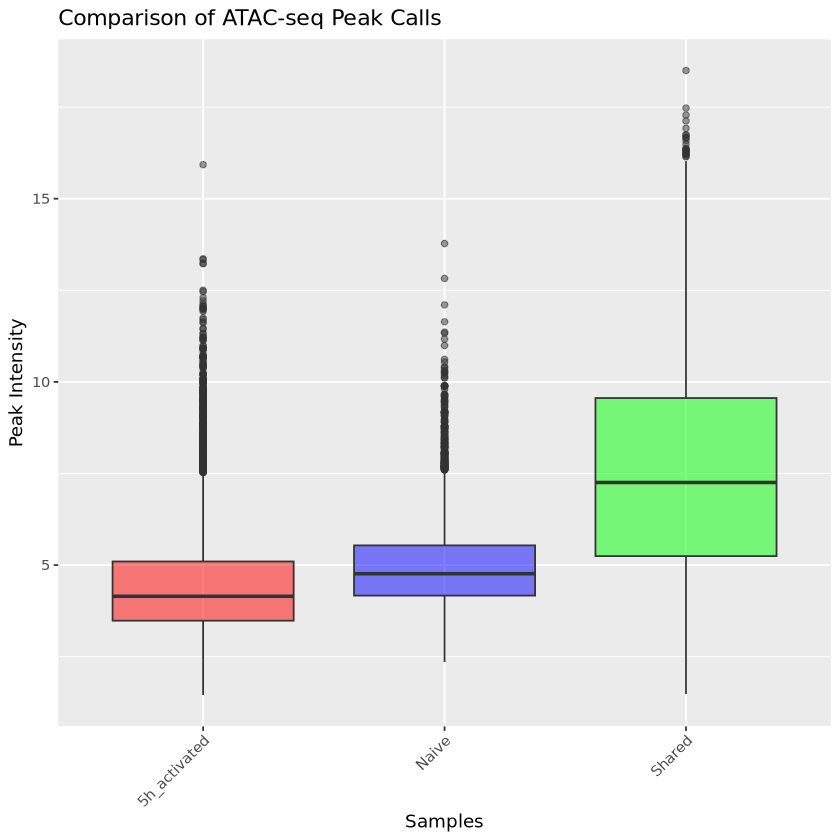

In [100]:
ggplot() +
  geom_boxplot(data = sample1_data, aes(x = Sample, y = signalValue), fill = "blue", alpha = 0.5) +
  geom_boxplot(data = sample2_data, aes(x = Sample, y = signalValue), fill = "red", alpha = 0.5) +
  geom_boxplot(data = sample3_data, aes(x = Sample, y = signalValue), fill = "green", alpha = 0.5) +
  labs(title = "Comparison of ATAC-seq Peak Calls", x = "Samples", y = "Peak Intensity") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### COR　VS　NOR　VS　EOR

EOR、COR、NORの遺伝子の領域がどこか特定し、その遺伝子の領域について、ピークを抽出する。  
データはnarrowPeakファイルを使用する。  
EORはJAk2/IL2、NORはKLF2、CORはEGR2があげられる。  
JAK2,IL2,KLF2,EGR2について、遺伝子座を特定する。  
narrowPeakファイルにおいて、遺伝子座の数値の範囲にstartもしくはendが含まれているという条件に当てはまるscoreを抽出して、棒グラフにする。

In [ ]:
# 使用するライブラリの読み込みを行う
library(org.Hs.eg.db)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(AnnotationDbi)

In [ ]:
# 使用するライブラリが正常に動作しているか確認する
library(org.Hs.eg.db)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(AnnotationDbi)

In [70]:
# TxDbオブジェクトを作成する
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene

In [85]:
# 遺伝子名を指定する
gene_names <- c("IL2", "KLF2", "EGR2")

In [86]:
# 遺伝子座を格納するリストを初期化する
gene_loci <- list()

In [87]:
# 各遺伝子について遺伝子座を取得し、リストに追加する
for (gene_name in gene_names) {
  # 遺伝子IDを取得する
  gene_id <- mapIds(org.Hs.eg.db, keys = gene_name, column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
  
  # 遺伝子座の情報を取得する
  gene_info <- genes(txdb, filter = list(gene_id = gene_id))
  
  # 遺伝子座のstartとendを取得し、リストに追加する
  if (length(gene_info) > 0) {
    start <- start(gene_info)
    end <- end(gene_info)
    gene_loci[[gene_name]] <- c(start, end)
  } else {
    cat("Gene not found:", gene_name, "\n")
  }
}


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [88]:
# 結果を表示する
print(gene_loci)

$IL2
[1] 123372626 123377650

$KLF2
[1] 16435651 16438339

$EGR2
[1] 64571756 64578927



In [89]:
# narrowPeakファイルを読み込み、スコアを抽出する関数を定義する
filter_scores <- function(file_path, gene_loci) {
  df <- read.table(file_path, header = FALSE)
  colnames(df) <- c('chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak')
  
  gene_scores <- lapply(names(gene_loci), function(gene) {
    locus <- gene_loci[[gene]]
    scores <- df %>%
      filter((start >= locus[1] & start <= locus[2]) | (end >= locus[1] & end <= locus[2])) %>%
      pull(score)
    return(scores)
  })
  
  names(gene_scores) <- names(gene_loci)
  return(gene_scores)
}

In [90]:
# ファイルを読み込む
naive_scores <- filter_scores('/home/inou_doi/demo/3_peak_call/MACS2_def/SRR7475870_peaks.narrowPeak', gene_loci)
activated_scores <- filter_scores('/home/inou_doi/demo/3_peak_call/MACS2_def/SRR7475873_peaks.narrowPeak', gene_loci)

In [91]:
# スコアを合計する
naive_sum <- sapply(naive_scores, sum)
activated_sum <- sapply(activated_scores, sum)

In [92]:
# データフレームを作成する
naive_data <- data.frame(
  Gene = names(naive_sum),
  Score = naive_sum,
  Condition = 'Naive'
)

activated_data <- data.frame(
  Gene = names(activated_sum),
  Score = activated_sum,
  Condition = 'Activated'
)


In [79]:
# データフレームの内容を表示する
print(naive_data)

     Gene Score Condition
JAK2 JAK2  3923     Naive
KLF2 KLF2   541     Naive
EGR2 EGR2   459     Naive


In [80]:
# データフレームの内容を表示する
print(activated_data)

     Gene Score Condition
JAK2 JAK2  4554 Activated
KLF2 KLF2   585 Activated
EGR2 EGR2   398 Activated


In [81]:
# JAK2とIL2をEORとして、KLF2をNORとして、EGR2をCORとしてまとめる
naive_data$Gene <- recode(naive_data$Gene, 'JAK2' = 'EOR', 'KLF2' = 'NOR', 'EGR2' = 'COR')
activated_data$Gene <- recode(activated_data$Gene, 'JAK2' = 'EOR', 'KLF2' = 'NOR', 'EGR2' = 'COR')

In [82]:
# スコアを合計する
naive_data <- naive_data %>%
  group_by(Gene, Condition) %>%
  summarise(Score = sum(Score))

activated_data <- activated_data %>%
  group_by(Gene, Condition) %>%
  summarise(Score = sum(Score))

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.


In [83]:
# データフレームを結合する
combined_data <- bind_rows(naive_data, activated_data)

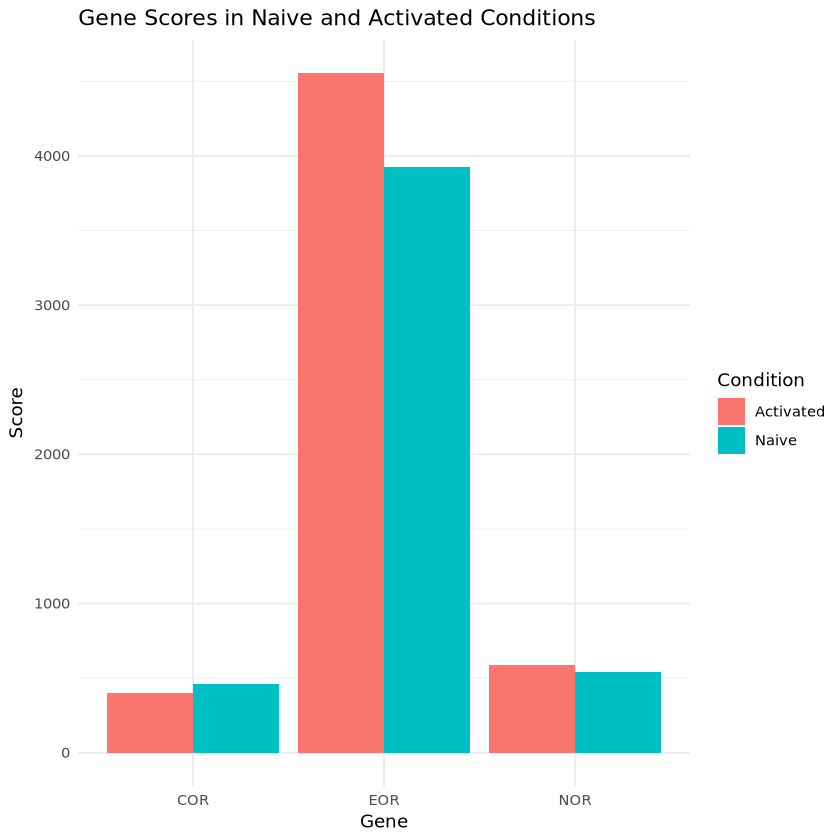

In [84]:
# 棒グラフを作成する
ggplot(combined_data, aes(x = Gene, y = Score, fill = Condition)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  labs(title = 'Gene Scores in Naive and Activated Conditions', y = 'Score') +
  theme_minimal()